In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline  
from patsy import dmatrices
from sklearn.linear_model import Lasso,LassoCV, RidgeCV, Ridge, LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

In [154]:
houseData = pd.read_csv("Kaggle/train.csv")
houseDataTest = pd.read_csv("Kaggle/test.csv")
houseData.shape

(1460, 81)

#### Remove outliers for sale price

In [3]:
# np.percentile(houseData['SalePrice'], q=99.5)



#### Impute missing values

In [155]:
# Re-label MSSubClass into 3 categories based on SalePrice range and value counts
def mssub_label(x):
    if x == 20:
        return '1S-NEWER'
    elif x == 60:
        return '2S-NEWER'
    elif x == 50:
        return '1.5S-FINISHED'
    elif x == 120:
        return '1S-PUD'
    else:
        return 'Other'

houseData['MSSubClass'] = houseData['MSSubClass'].map(mssub_label)

# Impute missing values in Lot Frontage with mean
lot_frontage_mean = houseData['LotFrontage'].mean()
houseData['LotFrontage'] = houseData['LotFrontage'].map(lambda x: lot_frontage_mean if (np.isnan(x)) else x)

# Impute nan function for categorical variables
def impute_nan(feature_list, impute_value):
    for feature in feature_list:
        houseData[feature] = houseData[feature].map(lambda x: impute_value if type(x) != str else x)
        
# Alley
impute_nan(['Alley'], 'No Alley')

# Basement
basement_features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
impute_nan(basement_features, 'No Basement')

# Veneer
veneer_features = ['MasVnrType']
impute_nan(veneer_features, 'No Veneer')
houseData['MasVnrArea'] = houseData['MasVnrArea'].map(lambda x: 0 if (np.isnan(x)) else x)

# Electrical - impute with most common type
impute_nan(['Electrical'], 'SBrkr')

# Fireplace
impute_nan(['FireplaceQu'], 'No Fireplace')

# Garage - fill missing year with 0. May have to include year and garage binary as interaction if garage is important
impute_nan(['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], 'No Garage')
houseData['GarageYrBlt'] = houseData['GarageYrBlt'].map(lambda x: 0 if np.isnan(x) else int(x))

# Pool QC
impute_nan(['PoolQC'], 'No Pool')

# Fence
impute_nan(['Fence'], 'No Fence')

# Misc Features
impute_nan(['MiscFeature'], 'None')

In [156]:
# Baseline data

columns_to_drop = ['Id','SalePrice','GarageYrBlt','Alley']
predictors = houseData.drop(columns_to_drop, axis=1)
response = houseData['SalePrice']
predictors_dum = pd.get_dummies(predictors)

In [157]:
def nan_count():
    features_q6 = predictors.columns.values
    
    i = 0
    
    for feature in features_q6:
        num_null = houseData[feature].isnull().sum()
        if num_null > 0:
            print feature, num_null
            i += 1
    if i == 0:
        print "The data has no nulls!"

nan_count()

The data has no nulls!


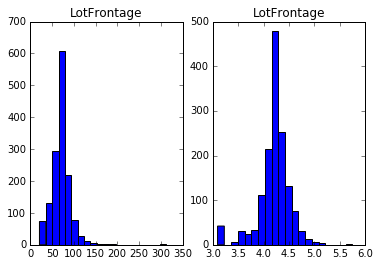

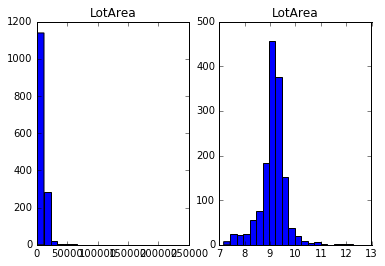

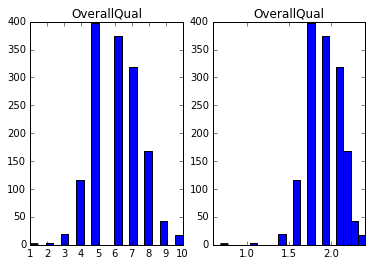

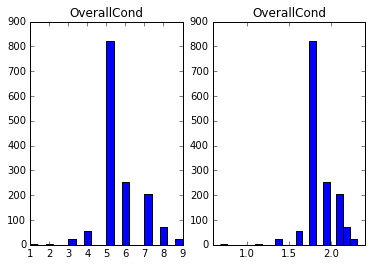

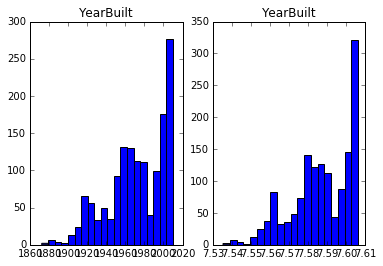

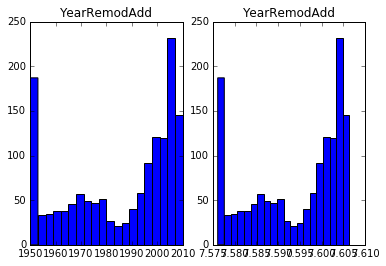

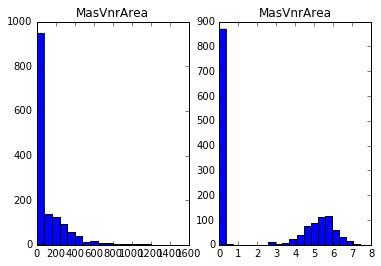

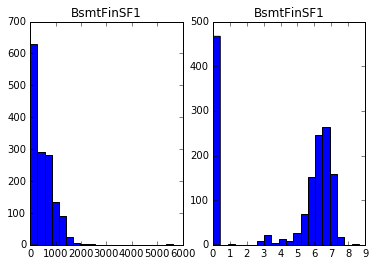

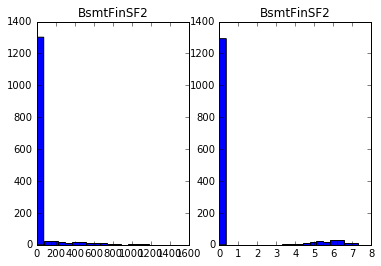

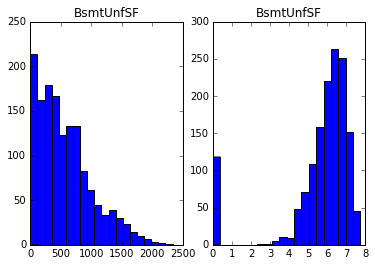

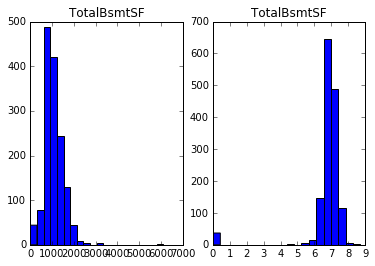

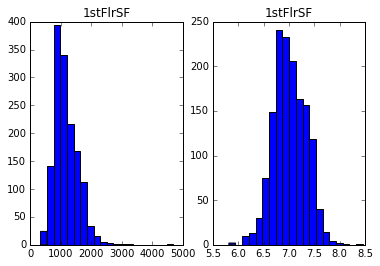

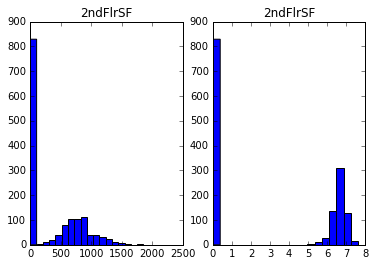

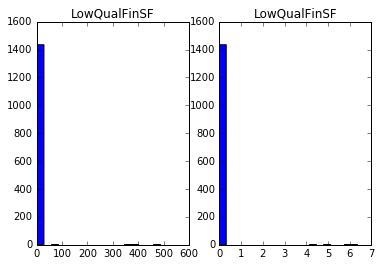

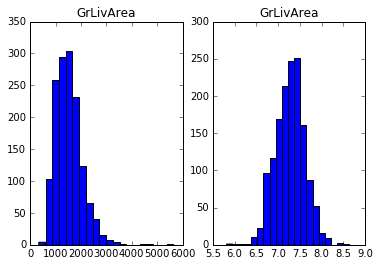

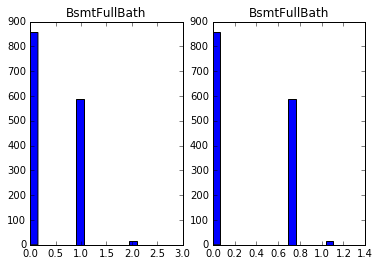

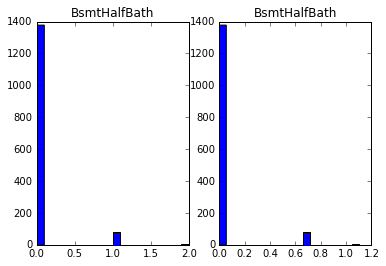

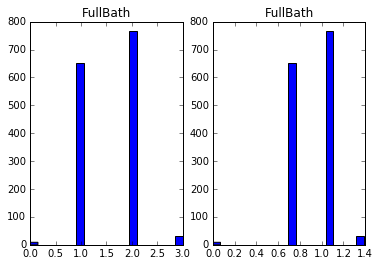

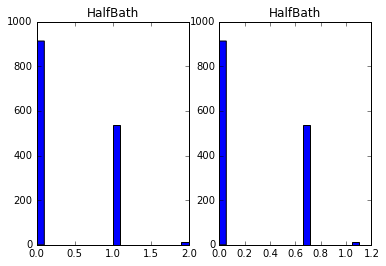

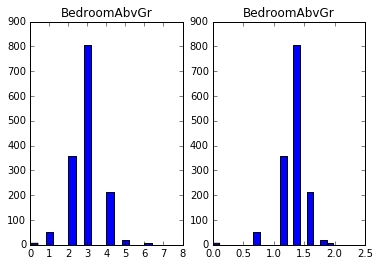

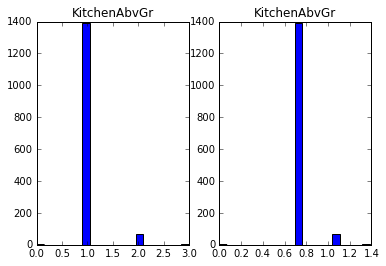

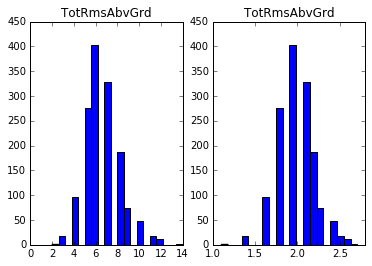

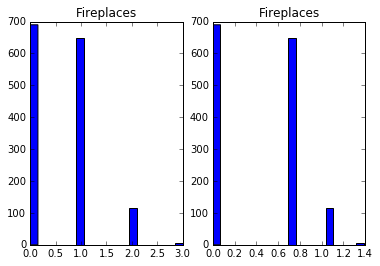

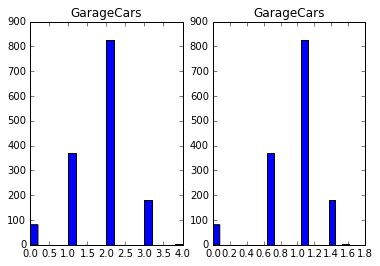

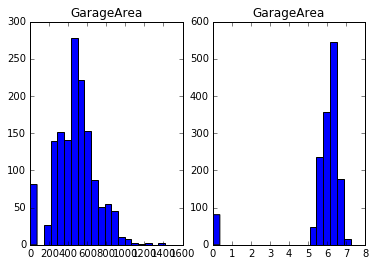

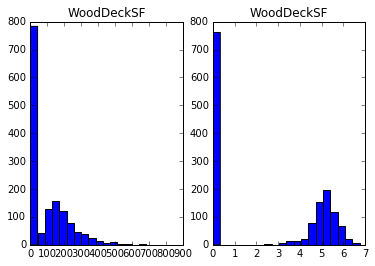

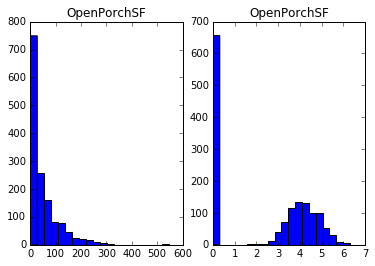

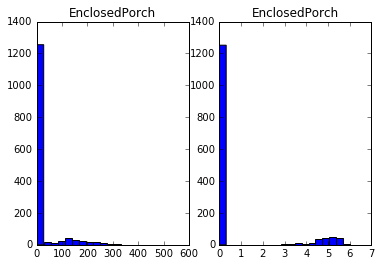

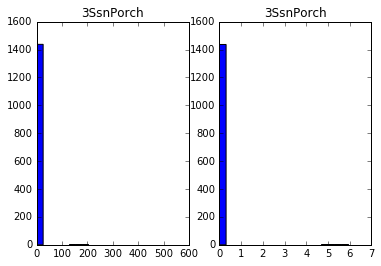

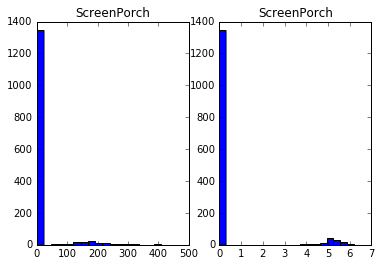

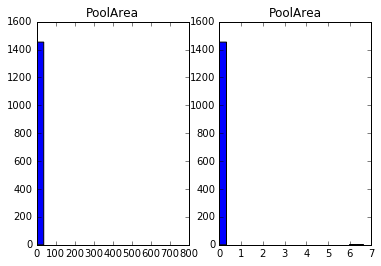

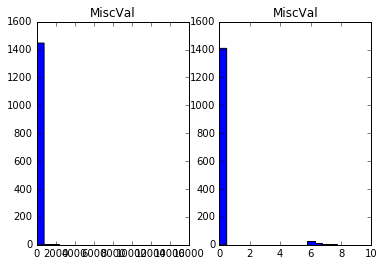

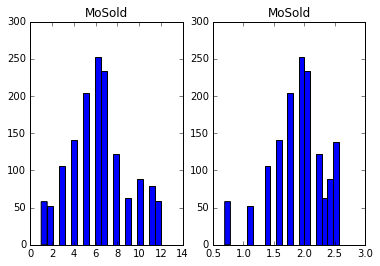

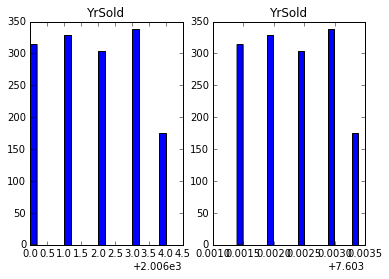

In [180]:
# See skew in continuous variables
continuous_feat = []

for feature in predictors.columns.values:
    if type(predictors[[feature]].iloc[0][0]) != str:
        continuous_feat.append(feature)

        
for feature in continuous_feat:
    f, (ax1, ax2) = plt.subplots(1,2)

    ax1.hist(predictors[feature], bins=20)
    ax1.set_title(feature)
    

    ax2.hist(np.log(predictors[feature]+1), bins=20)
    ax2.set_title(feature)

#### Remove/fix outliers

In [7]:
try:
    outliers_drop = [1298, 825, 523, 688, 1324]
    predictors_dum = predictors_dum.drop(outliers_drop)
    response = response.drop(outliers_drop)
except:
    pass

#### Feature reduction

In [8]:
# Random forest importance
rf = RandomForestRegressor(min_samples_leaf=7)
rf.fit(predictors_dum, response)

rf_feature_weights = []
for index, col in enumerate(predictors_dum.columns.values):
    rf_feature_weights.append((col, rf.feature_importances_[index]))

sorted(rf_feature_weights, key = lambda x: x[1], reverse = True)

[('OverallQual', 0.61486157967252086),
 ('GrLivArea', 0.14591264073671845),
 ('TotalBsmtSF', 0.03834504024077641),
 ('BsmtFinSF1', 0.035842695709443081),
 ('GarageCars', 0.027747241602321809),
 ('LotArea', 0.02340138751991382),
 ('GarageArea', 0.015484786785823438),
 ('1stFlrSF', 0.012931195848619847),
 ('MasVnrArea', 0.012583838859784952),
 ('YearRemodAdd', 0.0081496637953759801),
 ('YearBuilt', 0.0080999684086761371),
 ('TotRmsAbvGrd', 0.0065152104013009833),
 ('BsmtQual_Ex', 0.0061028910501196628),
 ('FireplaceQu_No Fireplace', 0.0042786897793175111),
 ('CentralAir_N', 0.0030551703782512847),
 ('OverallCond', 0.0029919912975816727),
 ('BsmtUnfSF', 0.0021933940014238216),
 ('CentralAir_Y', 0.0019114584367714055),
 ('LotFrontage', 0.0018865656836577599),
 ('2ndFlrSF', 0.00182255096314012),
 ('GarageType_Attchd', 0.0018045264911622603),
 ('WoodDeckSF', 0.0015419851369029105),
 ('GarageType_Detchd', 0.0014942121628182343),
 ('GarageFinish_Unf', 0.0013712925868070785),
 ('MSSubClass_Othe

In [9]:
# Ridge 
# Ridge
alphas =  10**np.linspace(10,-2,100)*0.5
ridge_cv = RidgeCV(alphas=alphas, cv=10)

ridge_cv.fit(predictors_dum, response)
best_lambda_lasso = ridge_cv.alpha_

coef_values = ridge_cv.coef_

features_q6 = predictors_dum.columns.values

features_coef_lasso = [(features_q6[i], coef_values[i]) for i in range(len(features_q6))]

print "Best lambda, Ridge: {:.3f}".format(best_lambda_lasso), '\n'

for tup in sorted(features_coef_lasso, key=lambda tup: tup[1], reverse=True):
    print "{}: {:.3f}".format(tup[0], tup[1])

Best lambda, Ridge: 12.385 

Neighborhood_NoRidge: 16947.685
RoofMatl_WdShngl: 15538.649
Neighborhood_StoneBr: 15500.002
KitchenQual_Ex: 14869.502
Neighborhood_Crawfor: 13211.036
ExterQual_Ex: 12440.498
BsmtExposure_Gd: 12292.747
Functional_Typ: 12172.736
BsmtQual_Ex: 11777.474
Exterior1st_BrkFace: 10250.442
BldgType_1Fam: 9020.009
Condition1_Norm: 8892.457
OverallQual: 7997.415
SaleType_New: 7978.365
Neighborhood_NridgHt: 7836.614
GarageQual_Ex: 7677.140
LotConfig_CulDSac: 7414.242
Street_Pave: 6431.941
OverallCond: 6031.638
HouseStyle_1Story: 5896.101
GarageCars: 5680.519
LandSlope_Mod: 5672.673
Neighborhood_BrkSide: 5584.820
PoolQC_Ex: 5255.489
Neighborhood_Somerst: 5208.957
HouseStyle_1.5Unf: 5198.153
Exterior2nd_ImStucc: 5087.230
MSZoning_RL: 4700.226
MasVnrType_Stone: 4695.192
MasVnrType_None: 4555.877
Neighborhood_NPkVill: 4359.760
Fireplaces: 3969.334
GarageType_BuiltIn: 3603.544
BsmtFinType2_ALQ: 3489.957
BsmtFinType2_GLQ: 3432.743
SaleCondition_Partial: 3227.237
HouseStyle_SL

In [10]:
# Features with highest variance
# Select only features with high variance

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.95*(1-.95)))
sel.fit(predictors_dum)
features_keep_idx = sel.get_support(indices=True)

# pd.DataFrame(sel.fit_transform(predictors_dum))
print len(features_keep_idx)

for feature in predictors_dum.columns.values[features_keep_idx]:
    print feature


136
LotFrontage
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
MSSubClass_1.5S-FINISHED
MSSubClass_1S-NEWER
MSSubClass_1S-PUD
MSSubClass_2S-NEWER
MSSubClass_Other
MSZoning_RL
MSZoning_RM
LotShape_IR1
LotShape_Reg
LandContour_Lvl
LotConfig_Corner
LotConfig_CulDSac
LotConfig_Inside
LandSlope_Gtl
Neighborhood_CollgCr
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_NAmes
Neighborhood_NWAmes
Neighborhood_NridgHt
Neighborhood_OldTown
Neighborhood_Sawyer
Neighborhood_Somerst
Condition1_Feedr
Condition1_Norm
BldgType_1Fam
BldgType_TwnhsE
HouseStyle_1.5Fin
HouseStyle_1Story
HouseStyle_2Story
RoofStyle_Gable
RoofStyle_Hip
Exterior1st_HdBoard
Exterior1st_MetalSd
Exterior1st_Plywood
Ext

In [11]:
neighborhood_mean_price = []

for neighborhood in predictors['Neighborhood'].value_counts().index:
    neighborhood_mean_price.append((neighborhood,response[predictors['Neighborhood'] == neighborhood].mean()))
    
for tup in sorted(neighborhood_mean_price, key=lambda tup: tup[1], reverse=True):
    print tup

('NoRidge', 335295.31707317074)
('NridgHt', 315366.2894736842)
('StoneBr', 307103.125)
('Timber', 242247.44736842104)
('Veenker', 238772.72727272726)
('Somerst', 226301.95294117648)
('ClearCr', 212565.42857142858)
('Crawfor', 210624.72549019608)
('CollgCr', 197965.77333333335)
('Blmngtn', 194870.88235294117)
('Gilbert', 192854.50632911394)
('NWAmes', 189050.0684931507)
('SawyerW', 186555.7966101695)
('Mitchel', 156270.1224489796)
('NAmes', 145847.08)
('NPkVill', 142694.44444444444)
('SWISU', 142591.36)
('Blueste', 137500.0)
('Sawyer', 136793.13513513515)
('OldTown', 128225.30088495575)
('Edwards', 127318.57142857143)
('BrkSide', 124834.05172413793)
('BrDale', 104493.75)
('IDOTRR', 100123.78378378379)
('MeadowV', 98576.4705882353)


#### Evaluate model via train-test split - baseline (little feature reduction)

In [12]:
def rmse_calc(actual, predict):
    return np.mean((actual - predict)**2)**0.5

Linear Regression (baseline): 24102.9271753
Ridge (baseline): 19219.0990532
Lasso (baseline): 31245.3548705


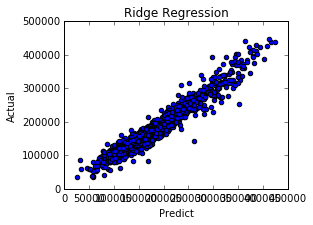

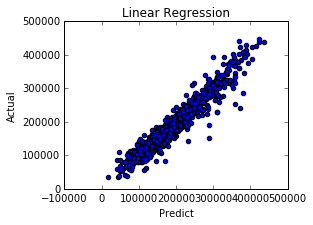

In [26]:
# Baseline RMSE - plug everything in and see what we get. Exclude houses that are higher tan $450K

price_mask = response < 450000
# 
X_train, X_test, y_train, y_test = train_test_split(predictors_dum[price_mask], response[price_mask], test_size = 0.3)

# Linear Regression
linear_baseline = LinearRegression()
linear_baseline.fit(X_train, y_train)

rmse_lm_baseline = []

print "{}: {}".format("Linear Regression (baseline)",rmse_calc(y_test, linear_baseline.predict(X_test)))

# Ridge
alphas =  10**np.linspace(10,-2,20)*0.5
ridge_baseline = RidgeCV(alphas=alphas, cv=10)
ridge_baseline.fit(X_train, y_train)
print "{}: {}".format("Ridge (baseline)",rmse_calc(y_test, ridge_baseline.predict(X_test)))

# Lasso
lasso_baseline = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_baseline.fit(X_train, y_train)
print "{}: {}".format("Lasso (baseline)",rmse_calc(y_test, lasso_baseline.predict(X_test)))


plt.figure(figsize=(4,3))
plt.scatter(ridge_baseline.predict(predictors_dum[price_mask]), response[price_mask])
plt.title("Ridge Regression")
plt.xlabel("Predict")
plt.ylabel("Actual")

plt.figure(figsize=(4,3))
plt.scatter(linear_baseline.predict(predictors_dum[price_mask]), response[price_mask])
plt.title("Linear Regression")
plt.xlabel("Predict")
plt.ylabel("Actual")


In [15]:
lm_outlier = pd.DataFrame({'predict':linear_baseline.predict(predictors_dum[price_mask]), 'actual':response[price_mask]})
lm_outlier['residual'] = ((lm_outlier['predict'] - lm_outlier['actual'])**2)**0.5

lm_outlier['residual'].order(ascending=False)
# houseData.iloc[1298]

774     9.521580e+04
632     8.656374e+04
346     8.546987e+04
473     8.324345e+04
197     8.002296e+04
581     7.784826e+04
583     7.646626e+04
1181    6.898818e+04
681     5.952331e+04
1142    5.917196e+04
1211    5.879659e+04
218     5.777915e+04
1267    5.737943e+04
318     5.721083e+04
377     5.716974e+04
945     5.639527e+04
873     5.462693e+04
1453    5.292004e+04
231     5.164165e+04
13      5.162621e+04
664     5.155887e+04
261     5.111900e+04
728     5.011041e+04
462     4.999134e+04
1065    4.857691e+04
955     4.820345e+04
678     4.802699e+04
48      4.800624e+04
496     4.764864e+04
1386    4.720233e+04
            ...     
593     8.145026e+01
285     7.883868e+01
1418    5.033625e+01
210     4.976601e+01
271     1.255074e-06
1186    1.056702e-06
1248    5.840557e-07
1370    5.707843e-07
153     5.639740e-07
595     4.167086e-07
1003    4.146714e-07
1270    3.384193e-07
666     3.232271e-07
1170    3.039022e-07
1457    3.011664e-07
599     2.966844e-07
1423    2.353

In [ ]:
# Scale numerical data for MLP
scaler_baseline = StandardScaler()
numerical_features = []

for i in range(len(predictors.columns.values)):
    if type(predictors.iloc[1,i]) != str:
        numerical_features.append(i)


In [ ]:
# predictors_scaled = predictors

# for index in numerical_features:
#     scaler_baseline.fit(predictors_scaled.iloc[:,index])
#     predictors_scaled.iloc[:,index] = pd.Series(scaler_baseline.fit_transform(predictors_scaled.iloc[:,index]))

# predictors_scaled_dum = pd.get_dummies(predictors_scaled)

# # Scale everything, even categorical
# predictors_scaled_dum_all = predictors_dum

# for feature in predictors_scaled_dum_all.columns.values:
#     scaler_baseline.fit(predictors_scaled_dum_all[feature])
#     predictors_scaled_dum_all[feature] = pd.Series(scaler_baseline.fit_transform(predictors_scaled_dum_all[feature]))


In [ ]:
# Create train and test using scaled data
# X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(predictors_scaled_dum_all, response, test_size = 0.3)

# # Pick optimal number of hidden nodes
# hidden_layers = list(range(1,100,2))
# mlp_base_rmse = []

# for i in hidden_layers:
#     mlp_baseline = MLPRegressor(hidden_layer_sizes=(i,),activation = 'tanh', solver = 'sgd', \
#                       learning_rate='constant', random_state=42, learning_rate_init = 0.0001)
#     mlp_baseline.fit(X_train_sc, y_train_sc)
#     mlp_base_rmse.append((i, rmse_calc(y_test_sc, mlp_baseline.predict(X_test_sc))))

# mlp_base_rmse



### Load test data and clean

In [132]:
# Re-label MSSubClass into 3 categories based on SalePrice range and value counts
def mssub_label(x):
    if x == 20:
        return '1S-NEWER'
    elif x == 60:
        return '2S-NEWER'
    elif x == 50:
        return '1.5S-FINISHED'
    elif x == 120:
        return '1S-PUD'
    else:
        return 'Other'

houseDataTest['MSSubClass'] = houseDataTest['MSSubClass'].map(mssub_label)

# Impute missing values in Lot Frontage with mean
lot_frontage_mean = houseDataTest['LotFrontage'].mean()
houseDataTest['LotFrontage'] = houseDataTest['LotFrontage'].map(lambda x: lot_frontage_mean if (np.isnan(x)) else x)

# Impute nan function for categorical variables
def impute_nan_test(feature_list, impute_value):
    for feature in feature_list:
        houseDataTest[feature] = houseDataTest[feature].map(lambda x: impute_value if type(x) != str else x)
        
# Alley
impute_nan_test(['Alley'], 'No Alley')

# Basement
basement_features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
impute_nan_test(basement_features, 'No Basement')

# Veneer
veneer_features = ['MasVnrType']
impute_nan_test(veneer_features, 'No Veneer')
houseDataTest['MasVnrArea'] = houseDataTest['MasVnrArea'].map(lambda x: 0 if (np.isnan(x)) else x)

# Electrical - impute with most common type
impute_nan_test(['Electrical'], 'SBrkr')

# Fireplace
impute_nan_test(['FireplaceQu'], 'No Fireplace')

# Garage - fill missing year with 0. May have to include year and garage binary as interaction if garage is important
impute_nan_test(['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], 'No Garage')
houseDataTest['GarageYrBlt'] = houseDataTest['GarageYrBlt'].map(lambda x: 0 if np.isnan(x) else int(x))

# Pool QC
impute_nan_test(['PoolQC'], 'No Pool')

# Fence
impute_nan_test(['Fence'], 'No Fence')

# Misc Features
impute_nan_test(['MiscFeature'], 'None')
impute_nan_test(['MSZoning'], 'RM')
impute_nan_test(['Utilities'], 'AllPub')
impute_nan_test(['Exterior1st','Exterior2nd'], 'VinylSD')
impute_nan_test(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath','BsmtHalfBath'], 0)
impute_nan_test(['KitchenQual'], 'TA')
impute_nan_test(['Functional'], 'Typ')
impute_nan_test(['GarageCars','GarageArea'], 0)
impute_nan_test(['SaleType'], 'WD')

In [134]:
# Drop columns
columns_to_drop = ['Id','GarageYrBlt','Alley']
predictors_test = houseDataTest.drop(columns_to_drop, axis=1)
predictors_dum_test = pd.get_dummies(predictors_test)

def nan_count_test():
    features_q6 = predictors_test.columns.values
    
    i = 0
    
    for feature in features_q6:
        num_null = houseDataTest[feature].isnull().sum()
        if num_null > 0:
            print feature, num_null
            i += 1
    if i == 0:
        print "The data has no nulls!"

nan_count_test()

The data has no nulls!


In [124]:
# Use same features from training

features_list_q6 = list((predictors_dum.columns.values))


In [119]:
print predictors_dum.shape
print predictors_dum_test.shape

(1455, 303)
(1459, 283)


In [138]:
test_df = {}
test_df = pd.DataFrame(test_df)

for feature in features_list_q6:
    try:
        test_df[feature] = predictors_dum_test[feature]
    except:
        test_df[feature] = 0



In [152]:
# Make ridge predict

alphas =  10**np.linspace(10,-2,20)*0.5
ridge_final = RidgeCV(alphas=alphas, cv=10)
ridge_final.fit(predictors_dum, response)

predict_ridge = ridge_final.predict(test_df)
id_house = houseDataTest['Id']

predict_ridge_df = pd.DataFrame({'Id':id_house, 'SalePrice':predict_ridge})

predict_ridge_df.to_csv('ridge_predictions.csv', index=False)